In [ ]:
from Resampling import Resampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Illustration of resampling with the predictions of xgboost and random forest for age and gender
dataset_gender = pd.read_csv('output/Noisy_Classifiers/gender_predictions.csv')[['user_id','xgb']]
dataset_age = pd.read_csv('output/Noisy_Classifiers/age_predictions.csv')[['user_id','rf']]

In [ ]:
dataset = dataset_gender.merge(dataset_age, on = 'user_id').rename(columns = {'user_id':'id',
                                                                              'xgb':'dem_gender',
                                                                              'rf':'dem_age'})

In [ ]:
dataset.groupby(['dem_gender','dem_age']).size().sort_index() / dataset.shape[0]

dem_gender  dem_age
0           0          0.019544
            1          0.296368
            2          0.031782
            3          0.056977
1           0          0.024079
            1          0.216103
            2          0.101069
            3          0.254076
dtype: float64

In [ ]:
dataset['dem'] = dataset.apply(lambda row : row['dem_age'] if row['dem_gender'] == 0 
                               else row['dem_age'] + 4 ,axis = 1)

Compute the census and twitter distributions. Female age categories come first [0..3] and are followed by the Male age categories [4..7]

In [ ]:
census = np.array([0.1,0.08,0.08,0.27, 0.1,0.07,0.07,0.23])
twitter = np.array([0.02,0.296,0.032,0.057,   #Female age categories
              0.024,0.216,0.101,0.254])    #Male age categories                        

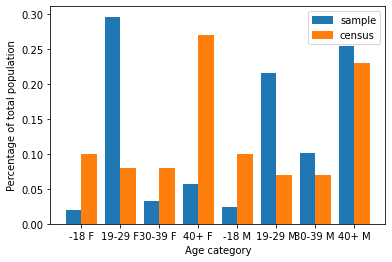

In [ ]:
colors = {'sample':'#1f77b4', 'census':'#ff7f0e'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(x= np.array([0,1,2,3,4,5,6,7])  -0.2, height = f, width = 0.4)
plt.bar(x =  np.array([0,1,2,3,4,5,6,7]) +0.2, height = T, width = 0.4)
plt.xticks(ticks = [0,1,2,3,4,5,6,7], labels = ['-18 F','19-29 F','30-39 F ','40+ F','-18 M','19-29 M','30-39 M ','40+ M'] )
plt.ylabel('Percentage of total population')
plt.xlabel('Age category');

The hyperparameters of the resampler, N and n, are determinant in the quality of the sample obtained.

In [ ]:
resampler = Resampler(N = 20000, n = 50)
resampler.fit(T,f)

In [ ]:
Q = resampler.get_transition_matrix()
Q  #Transition Matrix

[array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254]),
 array([0.02 , 0.296, 0.032, 0.057, 0.024, 0.216, 0.101, 0.254])]

In [ ]:
A = resampler.get_acceptance_matrix()
A  #Acceptance Matrix

array([[1.     , 0.0016 , 0.0016 , 0.0054 , 0.002  , 0.0014 , 0.0014 ,
        0.0046 ],
       [0.0296 , 1.     , 0.02368, 0.07992, 0.0296 , 0.02072, 0.02072,
        0.06808],
       [0.0032 , 0.00256, 1.     , 0.00864, 0.0032 , 0.00224, 0.00224,
        0.00736],
       [0.0057 , 0.00456, 0.00456, 1.     , 0.0057 , 0.00399, 0.00399,
        0.01311],
       [0.0024 , 0.00192, 0.00192, 0.00648, 1.     , 0.00168, 0.00168,
        0.00552],
       [0.0216 , 0.01728, 0.01728, 0.05832, 0.0216 , 1.     , 0.01512,
        0.04968],
       [0.0101 , 0.00808, 0.00808, 0.02727, 0.0101 , 0.00707, 1.     ,
        0.02323],
       [0.0254 , 0.02032, 0.02032, 0.06858, 0.0254 , 0.01778, 0.01778,
        1.     ]])

We perform the resampling 10 times and return the average distribution of the collected sample. It should approach the census distribution.

In [ ]:
def average_resampling(resampler, dataset, n_trials = 10):

  dist = pd.Series([0,0,0,0,0,0,0,0])
  for i in range(n_trials):
    sample = resampler.resample(dataset)
    dist =  dist +  sample.dem.value_counts(normalize = True).sort_index()

  dist /= n_trials
  return dist


In [ ]:
dist = average_resampling(resampler,dataset)

The sample still suffers from selection bias but the situation is already improved compared to the original dataset.

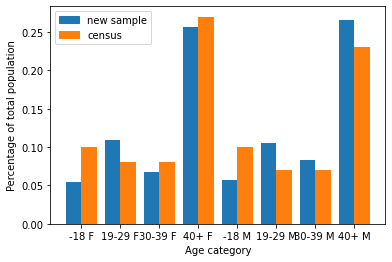

In [ ]:
colors = {'new sample':'#1f77b4', 'census':'#ff7f0e'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(x= dist.index -0.2, height = dist.values, width = 0.4)
plt.bar(x =  np.array([0,1,2,3,4,5,6,7]) +0.2, height = T, width = 0.4)
plt.xticks(ticks = [0,1,2,3,4,5,6,7], labels = ['-18 F','19-29 F','30-39 F ','40+ F','-18 M','19-29 M','30-39 M ','40+ M'] )
plt.ylabel('Percentage of total population')
plt.xlabel('Age category')
plt.plot();